# Imports

In [79]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm import tqdm
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import torchvision
from collections import defaultdict
import random

# Select GPU or TPU

use_gpu = True
if use_gpu:
  device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
else:
  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
  import os
  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
  # imports the torch_xla package
  import torch_xla
  import torch_xla.core.xla_model as xm
  # Creates a random tensor on xla:1 (a Cloud TPU core)
  device = xm.xla_device()
device

device(type='cuda', index=0)

In [99]:
ROOT = '/content/drive/MyDrive/NeuralPicasso/'

MODEL_PATH = os.path.join(ROOT, 'model')
DATA_PATH = os.path.join(ROOT, 'data') # '/content/drive/MyDrive/NeuralPicasso/data'
RESULT_PATH = os.path.join(ROOT, 'result')

NUMPY_PATH = os.path.join(DATA_PATH, 'numpy')
TRAIN_STROKE_PATH = os.path.join(DATA_PATH, 'train_strokes')
TRAIN_SKETCH_PATH = os.path.join(DATA_PATH, 'train_sketches')

ORIGIN_DATA_PATH = os.path.join(ROOT, 'orginal_data') # '/content/drive/MyDrive/NeuralPicasso/orginal data'
ORIGIN_NUMPY_PATH = os.path.join(ORIGIN_DATA_PATH, 'numpy')
ORIGIN_IMAGE_PATH = os.path.join(ORIGIN_DATA_PATH, 'image')

assert MODEL_PATH == '/content/drive/MyDrive/NeuralPicasso/model'

In [202]:
CATEGORY = 'blueberry'
AUTHOR = 'JHL'
MIN_LEN = 3
MAX_LEN = 30

In [203]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Utils

In [204]:
tensor_to_np = lambda x: x.cpu().detach().numpy()

In [205]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Model IO

In [206]:
class ModelIO():
    def __init__(self, model_path, category, timestamp=''):
        self.timestamp = timestamp
        self.category = category
        self.kmeans_path = os.path.join(model_path, self.timestamp, "KMeans", )
        self.pca_path = os.path.join(model_path, self.timestamp, "PCA",)
        self.sketchRNN_path = os.path.join(model_path, self.timestamp, "SketchRNN",  )
        self.strokeRNN_path = os.path.join(model_path, self.timestamp, "StrokeRNN", )
        self.startNN_path = os.path.join(model_path, self.timestamp, "StartNN",)


    def load_kmeans(self, epoch=''):
        path = os.path.join(self.kmeans_path, f'{self.category}_{epoch}_kmeans.pickle')
        with open(path, 'rb') as f:
            model = pickle.load(f)
        return model

    def load_pca(self, epoch=''):
        path = os.path.join(self.pca_path, f'{self.category}_{epoch}_pca.pickle')
        with open(path, 'rb') as f:
            model = pickle.load(f)
        return model

    def load_sketchRNN(self, epoch=''):
        path = os.path.join(self.sketchRNN_path, f'{self.category}_{epoch}_sketchRNN.pt')
        with open(path, 'rb') as f:
            model = torch.load(f, map_location=torch.device('cpu'))
        return model

    def load_strokeRNN(self, epoch=''):
        path = os.path.join(self.strokeRNN_path, f'{self.category}_{epoch}_strokeRNN.pt')
        with open(path, 'rb') as f:
            model = torch.load(f, map_location=torch.device('cpu'))
        return model

    def load_startNN(self, epoch=''):
        path = os.path.join(self.startNN_path, f'{self.category}_{epoch}_startNN.pt')
        with open(path, 'rb') as f:
            model = torch.load(f, map_location=torch.device('cpu'))
        return model

    def dump_kmeans(self, model, epoch=''):
        path = os.path.join(self.kmeans_path, f'{self.category}_{epoch}_kmeans.pickle')
        print(f'Saving Kmeans models to {path} ...')
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    def dump_pca(self, model, epoch=''):
        path = os.path.join(self.pca_path, f'{self.category}_{epoch}_pca.pickle')
        print(f'Saving PCA models to {path} ...')
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    def dump_startNN(self, model, epoch=''):
        path = os.path.join(self.startNN_path, f'{self.category}_{epoch}_startNN.pt')
        print(f'Saving startNN models {path}...')
        with open(path, 'wb') as f:
            torch.save(model, f)

    def dump_sketchRNN(self, model, epoch=''):
        path = os.path.join(self.sketchRNN_path, f'{self.category}_{epoch}_sketchRNN.pt')
        print(f'Saving sketchRNN models {path}...')
        with open(path, 'wb') as f:
            torch.save(model, f)

    def dump_strokeRNN(self, model, epoch=''):
        path = os.path.join(self.strokeRNN_path, f'{self.category}_{epoch}_strokeRNN.pt')
        print(f'Saving strokeRNN models {path}...')
        with open(path, 'wb') as f:
            torch.save(model, f)

In [207]:
io = ModelIO(MODEL_PATH, CATEGORY, AUTHOR)

# Data


In [208]:
def load_numpy_data(category):
    print(f'==== Loading {category} Data from Numpy Folder ====')
    with open(os.path.join(NUMPY_PATH, f'{category}.npy'), 'rb') as f:
        sketches = pickle.load(f)
    return sketches

## Stroke Train Data


In [209]:
class StrokeTrainData():
    def __init__(self, category, min_len=3, max_len=30):
        self.train_strokes = defaultdict(list) # map length to list of strokes
        self.min_len = min_len
        self.max_len = max_len
        self.category = category

        self.train_stroke_path = os.path.join(TRAIN_STROKE_PATH, self.category + '.pkl')

        if os.path.exists(self.train_stroke_path):
            self.load_strokes()
        else:
            numpy_data = load_numpy_data(self.category)
            self.load(numpy_data)

    def get_threshold(self):
        return self.min_len, self.max_len

    def load(self, data):
        # Load Numpy data to train strokes
        print('==== Construct Train Strokes ====')
        for sketch_idx, sketchs in enumerate(tqdm(data)):
            # for every stroke in the dataset, 
            for stroke_idx, stroke in enumerate(sketchs):
                length = len(stroke[0])
                # Remove Noise data
                if self.min_len < length <= self.max_len:
                    stroke = stroke.T
                    """ 
                        NOTE: 
                        The first point of relative_stroke is start point
                    """
                    relative_stroke = np.concatenate([[stroke[0]], np.diff(stroke, axis=0)], axis=0)
                    self.train_strokes[length].append(relative_stroke)

    def get_strokes(self):
        return self.train_strokes

    def load_strokes(self):
        print('==== Load Train Strokes ====')
        with open(self.train_stroke_path, 'rb') as f:
            self.train_strokes = pickle.load(f)

    def save_strokes(self):
        print('==== Save Train Strokes ====')
        with open(self.train_stroke_path, 'wb') as f:
            pickle.dump(self.train_strokes, f)


In [210]:
data_loader = StrokeTrainData(category=CATEGORY)

==== Loading blueberry Data from Numpy Folder ====
==== Construct Train Strokes ====


100%|██████████| 127878/127878 [00:04<00:00, 29871.07it/s]


In [211]:
train_strokes = data_loader.get_strokes()
len_ = 10
print('++++ DEMO ++++')
print(f'Train Strokes with length {len_}')
print(f'number: {len(train_strokes[len_])}')
print(f'demo data: {train_strokes[len_][0]}')
print(f'demo data type: {type(train_strokes[len_][0])}')

++++ DEMO ++++
Train Strokes with length 10
number: 22614
demo data: [[ 23  15]
 [-17   0]
 [ -6  15]
 [  5  13]
 [ 17  10]
 [  9   0]
 [  9  -5]
 [  3 -15]
 [-10 -12]
 [-20  -6]]
demo data type: <class 'numpy.ndarray'>


## Stroke

In [215]:
class Stroke():
    def __init__(self, data, category='UNK', label='NONE'):
        assert data.shape[0] > 1  and data.shape[1] == 2, f"Data shape should be (length > 1, 2), but get {data.shape}"

        self.data_ = data
        self.label_ = label
        self.category_ = category  
        self.length_ = data.shape[0]
        self.start_point_ = data[0]

    def set_label(self, label):
        self.label_ = label
    
    @property
    def label(self):
        return self.label_
    
    @property
    def start_point(self):
        return self.start_point_

    def visualize(self, pil_img=None, canvas=None, return_canvas=False):
        """
            Visualize the Stroke in ABSOLUTE DATA
            if pil_img is None, create and return the pil_img
        """

        if pil_img is None:
            W, H = 256, 256
            pil_img = Image.new('RGB', (W, H), 'white')
            canvas = ImageDraw.Draw(pil_img)

        __class__.draw_canvas(self.data_, canvas)
        
        if return_canvas:
            return pil_img, canvas
        else:
            return pil_img

    @staticmethod
    def draw_canvas(data, canvas, print_points=False):
        assert len(data) > 1 and len(data[0]) == 2 , "Data shape should be (length > 1, 2)"
        
        x, y = data[:, 0], data[:, 1]
        for i in range(1, len(x)):
            # NOTE: abs pos
            line = (x[i-1], y[i-1], x[i], y[i])
            if print_points:
                print(line)
            canvas.line(line, fill=0)

    @property        
    def data(self):
        return self.data_

    def __len__(self):
        return self.length_



In [216]:
# apple_data = load_numpy_data(CATEGORY)

In [217]:
# apple_sketch = apple_data[8]
# apple_stroke = apple_sketch[1]
# print(apple_stroke.T)
# Stroke(apple_stroke.T).visualize()

## Sketch

In [218]:
class Sketch():
    def __init__(self, data, category):
        self.category_ = category
        self.stroke_list_ = [Stroke(data=s.T, 
                                    category=self.category_) for s in data]

    def get_stroke_labels(self):
        return [s.label for s in self.stroke_list_]

    @property
    def stroke_list(self):
        return self.stroke_list_

    def labelize(self, model, pca, kmeans):
        for stroke in self.stroke_list_:
            encoder_inputs = np.diff(stroke.data_, axis=0)
            encoder_inputs = torch.tensor(encoder_inputs, dtype=torch.float32).view(-1, 1, 2).to(device)
            _, (hn, cn) = model.encoder(encoder_inputs)
            # after PCA
            hidden_vec = pca.transform(tensor_to_np(hn[-1, 0, :].reshape(1, -1))) # take the last stacked layer of hidden vector
            # KMEANS
            label_idx = kmeans.predict(hidden_vec)
            label_idx = np.squeeze(label_idx)
            label = f'{self.category_}_{label_idx}'
            stroke.set_label(label)
    
    def visualize(self, pil_img=None, canvas=None, return_canvas=False):
        if pil_img is None:
            W, H = 256, 256
            pil_img = Image.new('RGB', (W, H), 'white')
            canvas = ImageDraw.Draw(pil_img)

        for d in self.stroke_list_:
            d.visualize(pil_img, canvas)
        
        if return_canvas:
            return pil_img, canvas
        else:
            return pil_img


Relative Points:
[[151 -12 -34  -1 -44 -18  14 -19 -13 -15]
 [ 50 -48  -2  26 -24   8  32   2   5  17]]
Absolute Points:
[[151 139 105 104  60  42  56  37  24   9]
 [ 50   2   0  26   2  10  42  44  49  66]]


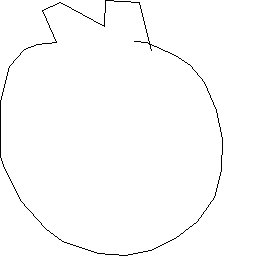

In [219]:
relative_stroke = train_strokes[30][0]
print('Relative Points:')
print(relative_stroke.T[:, 0:10])
absolute_stroke = np.cumsum(relative_stroke, axis=0)
print('Absolute Points:')
print(absolute_stroke.T[:, 0:10])
Stroke(absolute_stroke).visualize()

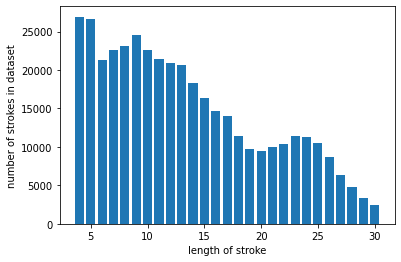

In [220]:
import matplotlib.pyplot as plt
# Show length distribution
lengths, nums = [], []

for k, v in train_strokes.items():
    lengths.append(k)
    nums.append(len(v))

plt.bar(lengths, nums)
plt.xlabel('length of stroke')
plt.ylabel('number of strokes in dataset')
plt.show()


# StrokeRNN

In [221]:
import torch 
import torch.nn as nn

## Model Definition

In [222]:

class StrokeRNN(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs_encoder, inputs_decoder):
        hiddens, enc_states = self.encoder(inputs_encoder)    
        output, dec_states = self.decoder(inputs_decoder, enc_states)
        return output

    def get_enc_states(self):
        return self.enc_states


class StrokeEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoder_dim, n_layers, proj_size, dropout=0.5):
        super(StrokeEncoder, self).__init__()
        # self.dropout = nn.Dropout(dropout)
        self.encoder_dim = encoder_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # self.proj_size = proj_size

        # encoder layers
        self.lstm = nn.LSTM( input_size = self.input_dim, 
                            hidden_size = self.hidden_dim, 
                            num_layers = self.n_layers)
        

    def forward(self, inputs, hidden=None):
        if hidden != None:
            hiddens, enc_states = self.lstm(inputs, hidden)
        else:    
            hiddens, enc_states = self.lstm(inputs)
        return hiddens, enc_states



class StrokeDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoder_dim, n_layers, output_dim, dropout=0.5, bidirectional=False):
        super(StrokeDecoder, self).__init__()
        # self.dropout = nn.Dropout(dropout)
        self.encoder_dim = encoder_dim
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # original fc
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.lstm = nn.LSTM(input_size = self.input_dim, 
                            hidden_size = self.hidden_dim, 
                            num_layers = self.n_layers)

    def forward(self, inputs, enc_states):
        hiddens, dec_states = self.lstm(inputs, enc_states) 
        # original fc
        output = self.fc(hiddens)
        return output, dec_states

## Train SktrokeRNN


In [223]:
"""
Stroke reconstruct 的效果不错
Decoder 一个 fc Layer
"""
epoch_size = 800
learning_rate = 0.005
input_dim = 2
hidden_dim = 128
n_layers = 2
proj_size = 2
output_dim = 2
encoder_dim = 2
batch_size = 256


device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [224]:
stroke_encoder = StrokeEncoder(input_dim, hidden_dim, encoder_dim, n_layers, proj_size)
stroke_decoder = StrokeDecoder(input_dim, hidden_dim, encoder_dim, n_layers, output_dim)

In [225]:
stroke_rnn = StrokeRNN(stroke_encoder, stroke_decoder).to(device)
optimizer = torch.optim.Adam(stroke_rnn.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

In [226]:
stroke_rnn.train()
for epoch in range(epoch_size):
    train_loss = 0
    for key, val in train_strokes.items():
        # get the chosen data according to the index list
        index_list = random.choices(list(range(len(val))), k=batch_size)
        data = np.array(val)[index_list]        
        # remove the start point in train strokes
        data = data[:, 1:, :] # (batch size, key-1, 2)
        # move batch size to 2nd dim
        data_transposed = torch.tensor(data, dtype=torch.float32).transpose(1, 0).to(device)
        ###########################
        #     Encoder Inputs      #
        ###########################
        encoder_inputs = data_transposed

        ###########################
        #     Decoder Inputs      #
        ###########################
        # adding zero as first point of decoder input
        zeros = torch.zeros((1, batch_size, 2)).to(device)
        after_cat = torch.cat((zeros, data_transposed), 0)
        decoder_inputs = after_cat[:-1, :, :]
        labels = data_transposed

        optimizer.zero_grad()
        ###########################
        #         Forward         #
        ###########################
        pred_seq = stroke_rnn.forward(encoder_inputs, decoder_inputs)

        ###########################
        #          Loss           #
        ###########################
        loss = loss_func(pred_seq, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size

    if epoch % 50 == 0:
        print(f'epoch: {epoch}, loss: {train_loss:.2f}, one loss: {loss:.2f}')


epoch: 0, loss: 2312521.25, one loss: 316.70
epoch: 50, loss: 305076.38, one loss: 87.07
epoch: 100, loss: 194543.69, one loss: 62.44
epoch: 150, loss: 149194.26, one loss: 54.46
epoch: 200, loss: 140188.28, one loss: 67.81
epoch: 250, loss: 140614.20, one loss: 53.85
epoch: 300, loss: 132454.87, one loss: 48.36
epoch: 350, loss: 129571.77, one loss: 48.36
epoch: 400, loss: 116332.04, one loss: 43.23
epoch: 450, loss: 114123.56, one loss: 38.20
epoch: 500, loss: 129655.52, one loss: 53.75
epoch: 550, loss: 134245.45, one loss: 59.66
epoch: 600, loss: 127303.42, one loss: 59.76
epoch: 650, loss: 112951.65, one loss: 52.49
epoch: 700, loss: 111204.78, one loss: 30.19
epoch: 750, loss: 111794.39, one loss: 41.31


## Reconstruct Stroke Without Start Point

--------- Origin --------- Generated ---------


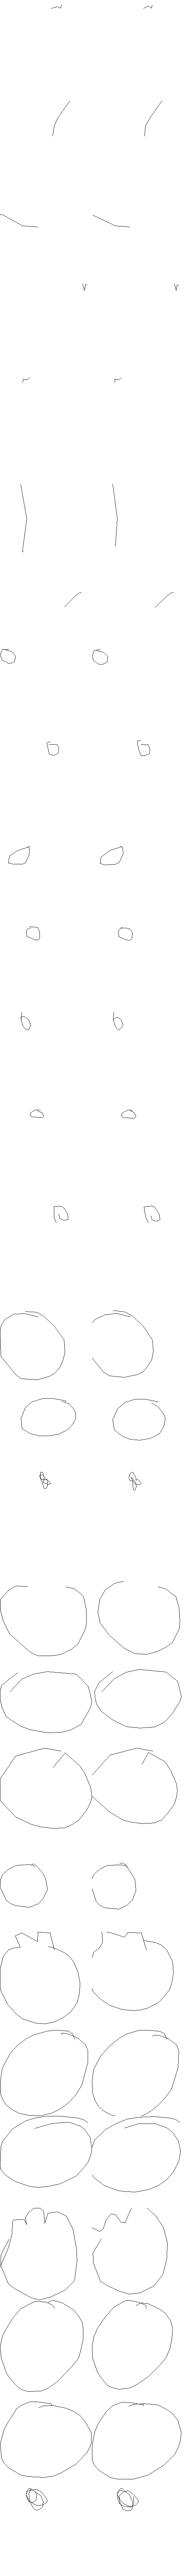

In [227]:
stroke_rnn.eval()

chosen_len_list = [4,10,20,30]
idx_list = list(range(0,7))

image_pais = []

for chosen_len in chosen_len_list:
    for idx in idx_list:
        # original stroke data *in relative format*
        origin_stroke = train_strokes[chosen_len][idx] 
        """
            NOTE: train_strokes format: [start_point, relative_1, relative_2]]
            Therefore generated stroke_length = chosen_len - 1
        """
        stroke_length = chosen_len - 1
        start_point = origin_stroke[0]
        encoder_inputs = torch.tensor(origin_stroke[1:], dtype=torch.float32)
        # add batch size in 2nd dimension to prepare for model input
        encoder_inputs = encoder_inputs[:, None, :].to(device)
        hiddens, enc_states = stroke_rnn.encoder(encoder_inputs)

        ######################
        #       Decoder      #
        ######################
        decoder_inputs = torch.zeros((1,1,2)).to(device)
        prev_state = enc_states
        res = []
        for i in range(stroke_length):
            output, prev_state = stroke_rnn.decoder(decoder_inputs, prev_state)
            decoder_inputs = output
            res.append(output.cpu().detach().numpy())
        
        origin_stroke_abs = np.cumsum(origin_stroke, axis=0)
        image_pais.append(Stroke(origin_stroke_abs).visualize())
        
        generate_stroke = np.array(res).reshape((stroke_length,2))
        generate_stroke = np.concatenate(([start_point],generate_stroke), axis=0)
        generate_stroke_abs = np.cumsum(generate_stroke, axis=0)
        
        image_pais.append(Stroke(generate_stroke_abs).visualize())

print('--------- Origin --------- Generated ---------')
image_grid(image_pais, len(chosen_len_list) * len(idx_list), 2)

# Clustering

## PCA

In [228]:
origin_hidden = [] # list of tuples [(seq_of_points with [stroke_len*2], hidden vector with [hidden size*1])]
for key, val in train_strokes.items():
    batch_size = len(val)
    inputs = torch.tensor(val, dtype=torch.float32).view(-1, batch_size, 2).to(device)
    enc_states = stroke_rnn.encoder(inputs) # h.shape (bi*n_layers, batch_size, hidden)
    hiddens, (h, c) = enc_states
    h_list = list(h[-1]) # take the last stacked layer of hidden vector
    for i_ in range(batch_size):
        origin_hidden.append((val[i_], h_list[i_].detach().cpu().numpy()))

In [229]:
# shuffle origin and hidden vector together
random.shuffle(origin_hidden)
len(origin_hidden)

403807

In [230]:
origin_hidden[0][1].shape

(128,)

In [231]:
hidden_list = [[hidden] for orign, hidden in origin_hidden]
hidden_vecs = np.concatenate(hidden_list, axis=0)
hidden_vecs.shape

(403807, 128)

In [232]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
pca.fit(hidden_vecs)

PCA(n_components=16)

In [233]:
pca_cluster = pca.transform(hidden_vecs)

In [234]:
pca_cluster.shape

(403807, 16)

## K-Means

In [235]:
from sklearn.cluster import KMeans, DBSCAN
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster).fit(pca_cluster)
# dbscan = DBSCAN().fit(pca_cluster)
# del cluster


In [236]:
labels = kmeans.labels_
# labels = dbscan.labels_
label2imgs = defaultdict(list)

N = 4000
for idx, label in enumerate(labels):
    if idx>N:
        break
    relative_stroke = origin_hidden[idx][0]
    absolute_stroke = np.cumsum(relative_stroke, axis=0)

    label2imgs[label].append(Stroke(absolute_stroke).visualize())

In [237]:
print(label2imgs.keys(), [len(v) for v in label2imgs.values()])

dict_keys([2, 0, 1]) [1364, 1446, 1191]


In [238]:
label2imgs.keys()

dict_keys([2, 0, 1])

## Demo

In [239]:
image_grid(label2imgs[2][0:1000], 20, 50) # apple0

In [240]:
image_grid(label2imgs[0][0:1000], 20, 50) # apple1

In [241]:
image_grid(label2imgs[1][0:1000], 20, 50)

# Save StrokeRNN Kmeans PCA 

In [242]:
# io.dump_kmeans(kmeans)
# io.dump_pca(pca)
# io.dump_strokeRNN(stroke_rnn)

In [243]:
# kmeans_ = io.load_kmeans()
# pca_ = io.load_pca()
# stroke_rnn_ = io.load_strokeRNN().to(device)
# print(stroke_rnn_)
# print(kmeans_)
# print(pca_)

# Labelize Data


1.   Map label to stroke data: ```label2stroke = {label: [stroke_np1, stroke_np2, ...]}```
2.   List of Sketch for training SketchRNN: ```train_sketches=[[Apple_1, Apple_2], ...]```


In [244]:
apple_np_data = load_numpy_data(CATEGORY)

==== Loading blueberry Data from Numpy Folder ====


In [245]:
stroke_images = []
label2stroke = defaultdict(list)
# label2img = defaultdict(list)
train_sketches = []

for apple in tqdm(apple_np_data):
    num_strokes = len(apple)
    if num_strokes >= 6:
        continue
    apple_sketch = Sketch(apple, category=CATEGORY)
    apple_sketch.labelize(stroke_rnn, pca, kmeans)
    stroke_labels = []
    for stroke in apple_sketch.stroke_list:
        length = stroke.data.shape[0]
        if MIN_LEN < length <= MAX_LEN:
            stroke_labels.append(stroke.label)
            label2stroke[stroke.label].append(stroke.data)
            # label2img[stroke.label].append(stroke.visualize())
    if 1 <= len(stroke_labels) <= 6:
        train_sketches.append(stroke_labels)

100%|██████████| 127878/127878 [04:55<00:00, 432.99it/s]


In [246]:
# DUMP
# with open(os.path.join(TRAIN_SKETCH_PATH, f'label2stroke.{CATEGORY}'), 'wb') as f:
#     pickle.dump(label2stroke, f)

# with open(os.path.join(TRAIN_SKETCH_PATH, f'train_sketches.{CATEGORY}'), 'wb') as g:
#     pickle.dump(train_sketches, g)

In [247]:
# LOAD
# with open(os.path.join(TRAIN_SKETCH_PATH, f'label2stroke.{CATEGORY}'), 'rb') as f:
#     label2stroke = pickle.load(f)

# with open(os.path.join(TRAIN_SKETCH_PATH, f'train_sketches.{CATEGORY}'), 'rb') as g:
#     train_sketches = pickle.load(g)

In [248]:
label2stroke.keys()

dict_keys(['blueberry_1', 'blueberry_2', 'blueberry_0'])

In [249]:
len(train_sketches)

91007

# Sketch Composer


## Sketch Data

In [250]:
train_sketches[100] # sketch: list of stroke labels

['blueberry_2', 'blueberry_2']

In [251]:
import random

stroke_names = set()

for sketch in train_sketches:
    for stroke in sketch:
        stroke_names.add(stroke)

stroke_names = list(stroke_names) + ['START', 'STOP']
print(stroke_names)

stroke2idx = {}
idx2stroke = {}
for idx, stroke in enumerate(stroke_names):
    stroke2idx[stroke] = idx
    idx2stroke[idx] = stroke

print(stroke2idx)

from collections import defaultdict
dummy_train_sketches = defaultdict(list)

for sketch in train_sketches:
    dummy_train_sketches[len(sketch)].append(['START'] + sketch + ['STOP'])

print(dummy_train_sketches.keys())
print('--------------')
print(dummy_train_sketches[2][1:10])

train_sketch_ids = {}

def sketch_to_id(sketches, stroke2idx):
    res = []
    for sketch in sketches:
        sketch_id = list(map(lambda x: stroke2idx[x], sketch))
        res.append(sketch_id)
    return res

for key, sketches in dummy_train_sketches.items():
    train_sketch_ids[key] = sketch_to_id(sketches, stroke2idx)

train_sketch_ids[3][0]


['blueberry_1', 'blueberry_2', 'blueberry_0', 'START', 'STOP']
{'blueberry_1': 0, 'blueberry_2': 1, 'blueberry_0': 2, 'START': 3, 'STOP': 4}
dict_keys([3, 5, 2, 4, 1])
--------------
[['START', 'blueberry_2', 'blueberry_0', 'STOP'], ['START', 'blueberry_2', 'blueberry_1', 'STOP'], ['START', 'blueberry_2', 'blueberry_1', 'STOP'], ['START', 'blueberry_2', 'blueberry_0', 'STOP'], ['START', 'blueberry_2', 'blueberry_1', 'STOP'], ['START', 'blueberry_2', 'blueberry_0', 'STOP'], ['START', 'blueberry_2', 'blueberry_0', 'STOP'], ['START', 'blueberry_2', 'blueberry_0', 'STOP'], ['START', 'blueberry_2', 'blueberry_0', 'STOP']]


[3, 0, 0, 1, 4]

## Model Definition

In [252]:
class SketchRNN(nn.Module):
    def __init__(self, encoder, decoder, stroke_num, stroke_vec_dim, latent_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.stroke_vec_dim = stroke_vec_dim
        self.stroke_num = stroke_num
        self.latent_size = latent_size        

        self.embedding = nn.Embedding(self.stroke_num, self.stroke_vec_dim)

        self.hidden2mean = nn.Linear(encoder.hidden_dim, self.latent_size)
        self.hidden2logv = nn.Linear(encoder.hidden_dim, self.latent_size)
        self.latent2hidden = nn.Linear(self.latent_size, decoder.hidden_dim)
    
    def index2vec(self, inputs):
        return self.embedding(inputs)

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, encoder_inputs, decoder_inputs):
        encoder_vecs = self.index2vec(encoder_inputs)
        decoder_vecs = self.index2vec(decoder_inputs)
        
        batch_size = encoder_vecs.shape[0]

        # Reshape Encoder Vectors into LSTM input format
        """ WARN: Do Not Use View !! """
        encoder_vecs = encoder_vecs.transpose(1,0) # [seq_len, batch_size, stroke_vec_dim]
        decoder_vecs = decoder_vecs.transpose(1,0) # [seq_len-1, batch_size, stroke_vec_dim]

        # Encoder
        hiddens, enc_states = self.encoder(encoder_vecs)
        h_n, c_n = enc_states

        # Reparameterization
        mu = self.hidden2mean(c_n)
        logv = self.hidden2logv(c_n)
        z = self.latent_sample(mu, logv)

        # Decoder
        c_0 = self.latent2hidden(z)
        dummy_h_0 = torch.zeros_like(h_n)

        hidden = (dummy_h_0, c_0)

        output, dec_states = self.decoder(decoder_vecs, hidden)
        return output, mu, logv

    def sample_latent_space(self, mu=0.0, std=1.0):
        return torch.normal(mu, std, size=(1, self.latent_size))


class SketchEncoder(nn.Module):
    def __init__(self, stroke_vec_dim, hidden_dim, n_layers):
        super(SketchEncoder, self).__init__()
        self.stroke_vec_dim = stroke_vec_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers


        # encoder layers
        self.lstm = nn.LSTM(input_size = self.stroke_vec_dim, 
                            hidden_size = self.hidden_dim, 
                            num_layers = self.n_layers)
    
    def forward(self, inputs, hidden=None):
        if hidden != None:
            hiddens, enc_states = self.lstm(inputs, hidden)
        else:    
            hiddens, enc_states = self.lstm(inputs)
        return hiddens, enc_states


class SketchDecoder(nn.Module):
    def __init__(self, stroke_vec_dim, hidden_dim, n_layers, output_dim):
        super(SketchDecoder, self).__init__()
        self.output_dim = output_dim
        self.stroke_vec_dim = stroke_vec_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # original fc
        self.lstm = nn.LSTM(input_size = self.stroke_vec_dim, 
                            hidden_size = self.hidden_dim, 
                            num_layers = self.n_layers)
        
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, inputs, enc_states):
        hiddens, dec_states = self.lstm(inputs, enc_states) 
        # original fc
        output = self.fc(hiddens)
        return output, dec_states

## Training

In [253]:
stroke_num = len(stroke2idx)
print(f'num of strokes: {stroke_num}')
# Encoder Decoder Parameter
input_dim = stroke_num
output_dim = stroke_num
hidden_dim = 128
n_layers = 1
stroke_vec_dim = 64

# VAE Parameters
latent_size = 16  # VAE

# Training parameter
batch_size = 32
epoch_size = 1000 
learning_rate = 0.005

num of strokes: 5


In [254]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [255]:
sketch_encoder = SketchEncoder(stroke_vec_dim, hidden_dim, n_layers)
sketch_decoder = SketchDecoder(stroke_vec_dim, hidden_dim, n_layers, output_dim)

In [256]:
sketch_rnn = SketchRNN(sketch_encoder, sketch_decoder, stroke_num, stroke_vec_dim, latent_size).to(device)
optimizer = torch.optim.Adam(sketch_rnn.parameters(), lr=learning_rate)
# org_loss_func = nn.CrossEntropyLoss()

In [257]:
# Loss Functions
ce_loss_func = nn.CrossEntropyLoss()

def kl_loss_func(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - torch.square(mu) - torch.exp(logvar))

def loss_func(preds, labels, mu, logvar):
    recon_loss = ce_loss_func(preds, labels)
    kl_loss = kl_loss_func(mu, logvar)
    return recon_loss, kl_loss

In [258]:
sketch_rnn.train()
for epoch in range(epoch_size):
    train_loss = 0
    for key, sketches in train_sketch_ids.items():
        # abandon sketches with stroke num >= 8
        if key >= 8:
            break
        # print(f'-----{key}-----')
        # get the chosen index
        num = len(sketches)
        index_list = random.choices(list(range(num)), k=batch_size)
        batch_sketch_ids = torch.Tensor(np.array(sketches))[index_list].to(device).to(torch.long)

        encoder_inputs = batch_sketch_ids
        decoder_inputs = batch_sketch_ids[:, :-1]
        labels = batch_sketch_ids[:, 1:]

        optimizer.zero_grad()

        pred, mu, logv = sketch_rnn.forward(encoder_inputs, decoder_inputs)
        # assert False
        pred = pred.transpose(1,0) # batch_size first
        pred = pred.reshape(-1, stroke_num) # unfold the prediction
        labels = labels.reshape(-1)
        
        recon_loss, kl_loss = loss_func(pred, labels, mu, logv)
        loss = recon_loss +  0.001 * kl_loss

        # original only reconstruction
        # loss = ce_loss_func(pred, labels)

        # assert False
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size

    if epoch % 20 == 0:
        print(f'epoch: {epoch}, train_loss: {train_loss:.2f}')


epoch: 0, train_loss: 233.42
epoch: 20, train_loss: 97.00
epoch: 40, train_loss: 70.06
epoch: 60, train_loss: 58.89
epoch: 80, train_loss: 53.44
epoch: 100, train_loss: 53.40
epoch: 120, train_loss: 52.30
epoch: 140, train_loss: 42.73
epoch: 160, train_loss: 45.82
epoch: 180, train_loss: 39.00
epoch: 200, train_loss: 42.09
epoch: 220, train_loss: 40.84
epoch: 240, train_loss: 42.09
epoch: 260, train_loss: 39.57
epoch: 280, train_loss: 40.94
epoch: 300, train_loss: 38.31
epoch: 320, train_loss: 42.08
epoch: 340, train_loss: 42.61
epoch: 360, train_loss: 39.04
epoch: 380, train_loss: 37.11
epoch: 400, train_loss: 39.60
epoch: 420, train_loss: 38.95
epoch: 440, train_loss: 39.65
epoch: 460, train_loss: 35.32
epoch: 480, train_loss: 38.65
epoch: 500, train_loss: 40.32
epoch: 520, train_loss: 36.95
epoch: 540, train_loss: 39.61
epoch: 560, train_loss: 39.14
epoch: 580, train_loss: 39.51
epoch: 600, train_loss: 35.38
epoch: 620, train_loss: 35.80
epoch: 640, train_loss: 37.26
epoch: 660, tra

## Generate

### Reconstruct

* input a sketch `['START', 'apple3', 'apple1', 'apple2', 'STOP']` into the encoder
* get hidden representation of the sketch
* put the hidden representation into the decoder and iteratively generate the sketch

In [259]:
def indexTensor2sketch(x):
    return list(map(lambda x: idx2stroke[x.item()], x))

print('### TEST AutoEncoder Reconstruct ')
sketch_rnn.eval()
len_limit = 20 # maximum generated length

for key, sketches in train_sketch_ids.items():
    if key >= 8:
        break
    print(f'---- Generate Len: {key} ----')
    num = len(sketches)
    index_list = random.choices(list(range(num)), k=1)
    batch_sketch_ids = torch.Tensor(np.array(sketches))[index_list].to(device).to(torch.long)
    print(indexTensor2sketch(batch_sketch_ids[0]))
    
    ######################
    #       Encoder      #
    ######################
    encoder_inputs = batch_sketch_ids
    encoder_vecs = sketch_rnn.index2vec(encoder_inputs)
    # Reshape Encoder Vectors into LSTM input format
    """ WARN: Do not use view !! """
    encoder_vecs = encoder_vecs.transpose(1,0)
    hiddens, enc_states = sketch_rnn.encoder(encoder_vecs)
    h_n, c_n = enc_states # c_n: (D∗num_layers,batch_size,H_cell)
    
    ######################
    #       Decoder      #
    ######################
    # initialized inputs
    decoder_inputs = batch_sketch_ids[:, 0:1]

    # Reparameterization
    mu = sketch_rnn.hidden2mean(c_n)
    logv = sketch_rnn.hidden2logv(c_n)
    z = sketch_rnn.latent_sample(mu, logv)

    # Decoder
    c_0 = sketch_rnn.latent2hidden(z)
    dummy_h_0 = torch.zeros_like(h_n)
    prev_states = (dummy_h_0, c_0)

    result = ['START']
    for i in range(len_limit):
        decoder_vecs = sketch_rnn.index2vec(decoder_inputs)
        # Reshape Encoder Vectors into LSTM input format
        """ WARN: Do not use view !! """
        decoder_vecs = decoder_vecs.transpose(1,0)
        pred, dec_states = sketch_rnn.decoder(decoder_vecs, prev_states)
        pred = pred.transpose(1,0).softmax(-1)[0]
        pred_idx = pred.argmax(1).view(1,-1)
        decoder_inputs, prev_states = pred_idx, dec_states
        generated_stroke = indexTensor2sketch(pred_idx)
        result += generated_stroke
        if generated_stroke[0] == 'STOP' or i == len_limit:
            break

    print(result)

### TEST AutoEncoder Reconstruct 
---- Generate Len: 3 ----
['START', 'blueberry_2', 'blueberry_1', 'blueberry_0', 'STOP']
['START', 'blueberry_2', 'blueberry_1', 'blueberry_0', 'STOP']
---- Generate Len: 5 ----
['START', 'blueberry_2', 'blueberry_1', 'blueberry_2', 'blueberry_2', 'blueberry_0', 'STOP']
['START', 'blueberry_2', 'blueberry_1', 'blueberry_2', 'blueberry_2', 'blueberry_0', 'STOP']
---- Generate Len: 2 ----
['START', 'blueberry_2', 'blueberry_0', 'STOP']
['START', 'blueberry_2', 'blueberry_0', 'STOP']
---- Generate Len: 4 ----
['START', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'blueberry_0', 'STOP']
['START', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'blueberry_0', 'STOP']
---- Generate Len: 1 ----
['START', 'blueberry_2', 'STOP']
['START', 'blueberry_2', 'STOP']


### Sample in latent space

In [260]:
len_limit = 10
generated_sketches_label = []
for _ in range(1000):
    print('------ Generate -------')
    ######################
    #       Decoder      #
    ######################
    # initialized inputs
    decoder_inputs = batch_sketch_ids[:, 0:1]

    z = torch.normal(0.0, 1.0, size=(1, sketch_rnn.latent_size)).to(device)
    z = z.view(n_layers*1, 1, latent_size) # (D∗num_layers,batch_size,latent_size)
    # z = sketch_rnn.sample_latent_space().view(n_layers*1, 1, latent_size) # (D∗num_layers,batch_size,latent_size)

    # Decoder
    c_0 = sketch_rnn.latent2hidden(z)
    dummy_h_0 = torch.zeros_like(h_n)
    prev_states = (dummy_h_0, c_0)

    result = ['START']
    for i in range(len_limit):
        decoder_vecs = sketch_rnn.index2vec(decoder_inputs)
        # Reshape Encoder Vectors into LSTM input format
        """ WARN: Do not use view !! """
        decoder_vecs = decoder_vecs.transpose(1,0)
        pred, dec_states = sketch_rnn.decoder(decoder_vecs, prev_states)
        pred = pred.transpose(1,0).softmax(-1)[0]
        pred_idx = pred.argmax(1).view(1,-1)
        decoder_inputs, prev_states = pred_idx, dec_states
        generated_stroke = indexTensor2sketch(pred_idx)
        result += generated_stroke
        if generated_stroke[0] == 'STOP':
            break

    print(result)
    generated_sketches_label.append(result)

    generated_len = len(result) - 2 # remove START and END
    rr = '|'.join(result)
    

    tt = ['|'.join(x) for x in dummy_train_sketches[generated_len]]
    tt = set(tt)
    print(rr in tt)

------ Generate -------
['START', 'blueberry_0', 'blueberry_2', 'blueberry_1', 'blueberry_0', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_2', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'blueberry_1', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_2', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'blueberry_0', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_0', 'blueberry_2', 'blueberry_0', 'blueberry_0', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'STOP']
True
------ Generate -------
['START', 'blueberry_2', 'blueberry_0', 'blueberry_1', 'blueberry_0', '

### Save Generated Results

In [261]:
GEN_LABEL_PATH = os.path.join(RESULT_PATH, f'generated_{CATEGORY}_label')
with open(GEN_LABEL_PATH, 'wb') as g:
    pickle.dump(generated_sketches_label, g)

# Start Point Predictor

In [262]:
# Freeze StrokeRNN Parameter
for param in stroke_rnn.encoder.parameters():
    param.requires_grad = False
for param in stroke_rnn.decoder.parameters():
    param.requires_grad = False

for name, param in stroke_rnn.encoder.named_parameters():
    print(name, tensor_to_np(param)[0])
    break
for name, param in stroke_rnn.decoder.named_parameters():
    print(name, tensor_to_np(param)[0][0])
    break

lstm.weight_ih_l0 [-0.01856145 -0.14839572]
fc.weight 1.6647977


In [263]:
class StartNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # FC layers for predicting start point
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, inputs):
        output = self.fc(inputs)
        return output


In [264]:
loss_func = nn.MSELoss()
epoch_size = 1000
batch_size = 512
input_dim = stroke_encoder.hidden_dim 

In [265]:
startNN = StartNN(input_dim).to(device)
optimizer = torch.optim.Adam(startNN.parameters(), lr=0.03)

In [266]:
def parse_enc_state(enc_states):
    hiddens, (hn, cn) = enc_states
    return hiddens[-1]

## Train

In [267]:
startNN.train()
stroke_rnn.eval()
for epoch in range(epoch_size):
    train_loss = 0
    for key, val in train_strokes.items():
        # get the chosen data according to the index list
        index_list = random.choices(list(range(len(val))), k=batch_size)
        data = np.array(val)[index_list]
        # Record Start points
        start_points = torch.tensor(data[:, 0, :], dtype=torch.float32).to(device)
        # remove the start point in train strokes
        data = data[:, 1:, :] # (batch size, key-1, 2)
        # move batch size to 2nd dim
        data_transposed = torch.tensor(data, dtype=torch.float32).transpose(1, 0).to(device)
        ###########################
        #     Encoder Inputs      #
        ###########################
        encoder_inputs = data_transposed

        optimizer.zero_grad()
        ###########################
        #         Forward         #
        ###########################
        enc_states = stroke_rnn.encoder.forward(encoder_inputs)

        """
            Note, batch first in FC
        """
        start_input = parse_enc_state(enc_states)
        pred_start = startNN.forward(start_input)
        ###########################
        #          Loss           #
        ###########################
        loss = loss_func(pred_start, start_points)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if epoch % 50 == 0:
        print(f'---------------- {epoch} --------------')
        print('pred: ', pred_start[0].cpu().detach().numpy())
        print('real: ', start_points[0].cpu().detach().numpy())
        print(f'loss: {train_loss:.2f}')

---------------- 0 --------------
pred:  [32.020138 12.152355]
real:  [194.   0.]
loss: 444635.77
---------------- 50 --------------
pred:  [77.05873  43.658127]
real:  [61. 66.]
loss: 84419.64
---------------- 100 --------------
pred:  [92.67004 53.24743]
real:  [131.  90.]
loss: 83276.01
---------------- 150 --------------
pred:  [159.6455    81.757614]
real:  [170.  19.]
loss: 80283.80
---------------- 200 --------------
pred:  [117.30721   65.282974]
real:  [125.  38.]
loss: 80344.05
---------------- 250 --------------
pred:  [104.735664  59.610695]
real:  [24. 26.]
loss: 79279.08
---------------- 300 --------------
pred:  [146.67511  74.09302]
real:  [223.   0.]
loss: 86149.74
---------------- 350 --------------
pred:  [89.076935 56.213806]
real:  [68. 85.]
loss: 79595.06
---------------- 400 --------------
pred:  [75.64856  41.306896]
real:  [186.  96.]
loss: 77375.76
---------------- 450 --------------
pred:  [111.88357  52.20332]
real:  [111.  30.]
loss: 79052.39
--------------

In [268]:
print('PLEASE make sure encoder decoder parameter dose not change!')

for name, param in stroke_rnn.encoder.named_parameters():
    print(name, tensor_to_np(param)[0])
    break


for name, param in stroke_rnn.decoder.named_parameters():
    print(name, tensor_to_np(param)[0][0])
    break


PLEASE make sure encoder decoder parameter dose not change!
lstm.weight_ih_l0 [-0.01856145 -0.14839572]
fc.weight 1.6647977


## Reconstruct Stroke With Start Point

Generated Start Point:[115.8327    65.697136] | Real Start Point: [143  23]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [146 122]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [105 119]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [229  22]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [63 40]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [23 15]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [136  23]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [83 51]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [85 21]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [60  0]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [106  80]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [181  60]
Generated Start Point:[115.8327    65.697136] | Real Start Point: [122  16]
Generated Start Point:

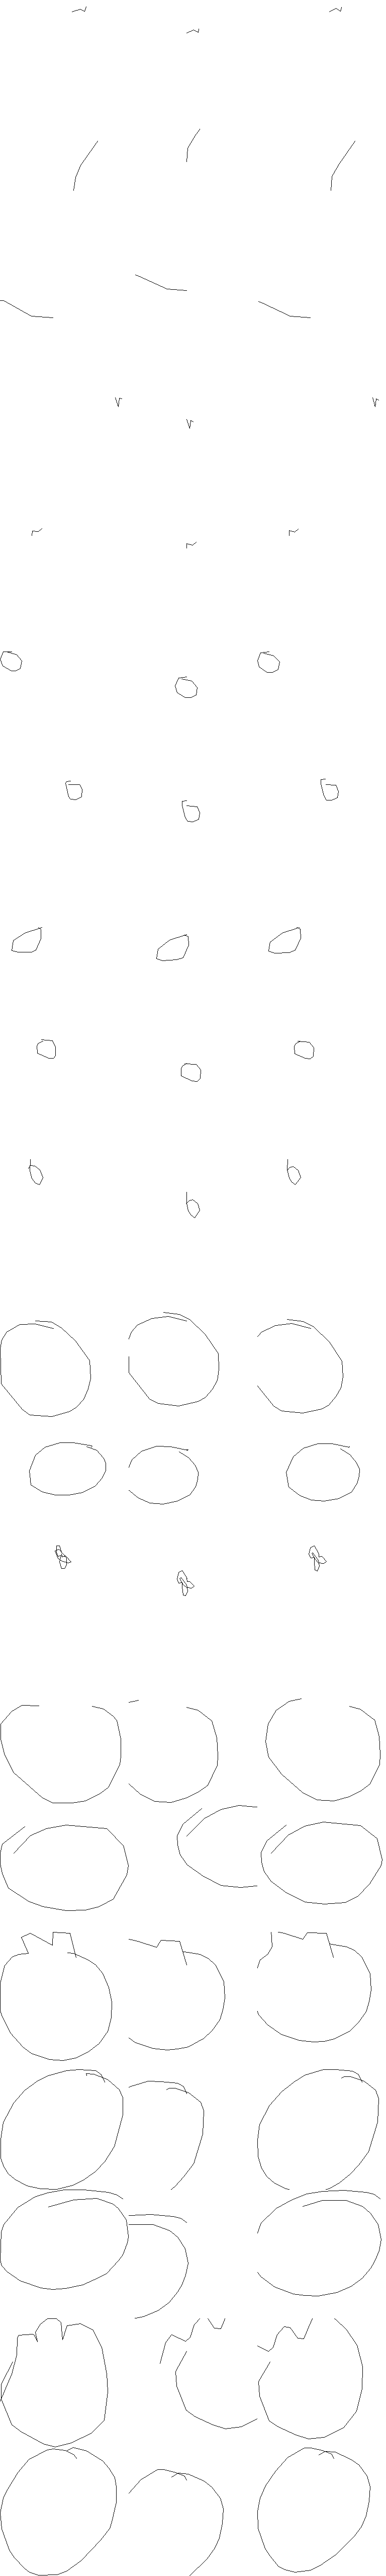

In [269]:
stroke_rnn.eval()
startNN.eval()
chosen_len_list = [4,10,20,30]
idx_list = list(range(0,5))

image_pais = []

for chosen_len in chosen_len_list:
    for idx in idx_list:
        # original stroke data *in relative format*
        origin_stroke = train_strokes[chosen_len][idx] 
        """
            NOTE: train_strokes format: [start_point, relative_1, relative_2]]
            Therefore generated stroke_length = chosen_len - 1
        """
        stroke_length = chosen_len - 1
        start_point = origin_stroke[0]
        encoder_inputs = torch.tensor(origin_stroke[1:], dtype=torch.float32)
        # add batch size in 2nd dimension to prepare for model input
        encoder_inputs = encoder_inputs[:, None, :].to(device)
        hiddens, enc_states = stroke_rnn.encoder(encoder_inputs)

        ##########################
        #       Pred Stroke      #
        ##########################
        decoder_inputs = torch.zeros((1,1,2)).to(device)
        prev_state = enc_states
        res = []
        for i in range(stroke_length):
            output, prev_state = stroke_rnn.decoder(decoder_inputs, prev_state)
            decoder_inputs = output
            res.append(output.cpu().detach().numpy())
        
        pred_stroke = np.array(res).reshape((stroke_length,2))

        ######################
        #   Start Point      #
        ######################
        start_input = parse_enc_state(enc_states)
        genearte_start = startNN(start_input).cpu().detach().numpy().reshape((1,2))
        print(f'Generated Start Point:{genearte_start[0]} | Real Start Point: {start_point}')
        
        ##########################
        #   Original Stroke      #
        ##########################
        origin_stroke_abs = np.cumsum(origin_stroke, axis=0)
        image_pais.append(Stroke(origin_stroke_abs).visualize())
        
        ##########################
        #   Generated Stroke     #
        ##########################
        generate_stroke = np.concatenate((genearte_start, pred_stroke), axis=0)
        generate_stroke_abs = np.cumsum(generate_stroke, axis=0)
        image_pais.append(Stroke(generate_stroke_abs).visualize())

        ##########################
        #       TMP   Stroke     #
        ##########################
        # With original start point
        tmp_stroke = np.concatenate(([start_point], pred_stroke), axis=0)
        tmp_stroke_abs =  np.cumsum(tmp_stroke, axis=0)
        image_pais.append(Stroke(tmp_stroke_abs).visualize())
        

print('--------- Origin --------- Generated --------- TMP ---------')
image_grid(image_pais, len(chosen_len_list) * len(idx_list), 3)

## Save Model

In [270]:
# io.dump_startNN(startNN)

# Neural Picasso

## Steps


1.   Generate sketch labels using `StrokeRNN`
2.   Sample stroke data according to labels
3.   Use `StrokeRNN` and `StartNN` to predict first point (or use the original first point in data)
4.   Compose!



## Generate with original start point

In [271]:
# Load Generated Sketch Labels
with open(GEN_LABEL_PATH, 'rb') as g:
    generated_sketches_label = pickle.load(g)
generated_sketches_label[0]

['START', 'blueberry_0', 'blueberry_2', 'blueberry_1', 'blueberry_0', 'STOP']

In [272]:
Generated_Sketches = []

for sketch_label in generated_sketches_label:
    sampled_stroke_list = []
    sketch_label = sketch_label[1:-1]
    for label in sketch_label:
        sampled_stroke = random.choices(label2stroke[label], k=1)[0]
        sampled_stroke_list.append(sampled_stroke.T)
    
    sketch_ = Sketch(sampled_stroke_list, CATEGORY)
    Generated_Sketches.append(sketch_)

In [273]:
imgs = [s.visualize() for s in Generated_Sketches]
image_grid(imgs[0:], 20, 50)

## Generate with StartNN

In [274]:
Generated_Sketches = []

for sketch_label in generated_sketches_label:
    sketch_label = sketch_label[1:-1]
    sampled_stroke_list = []
    for label in sketch_label:
        sampled_stroke = random.choices(label2stroke[label], k=1)[0]

        start_point = sampled_stroke[0]
        relative_sampled_stroke = np.diff(sampled_stroke, axis=0)
        encoder_inputs = torch.tensor(relative_sampled_stroke, dtype=torch.float32)
        # add batch size in 2nd dimension to prepare for model input
        encoder_inputs = encoder_inputs[:, None, :].to(device)
        hiddens, enc_states = stroke_rnn.encoder(encoder_inputs)

        ######################
        #   Start Point      #
        ######################
        start_input = parse_enc_state(enc_states)
        genearte_start = startNN(start_input).cpu().detach().numpy().reshape((1,2))
        # print(f'Generated Start Point:{genearte_start[0]} | Real Start Point: {start_point}')
        final_stroke = np.concatenate((genearte_start, sampled_stroke[1:]), axis=0)
        sampled_stroke_list.append(final_stroke.T)

    sketch_ = Sketch(sampled_stroke_list, CATEGORY)
    Generated_Sketches.append(sketch_)

In [ ]:
imgs = [s.visualize() for s in Generated_Sketches]
image_grid(imgs[0:len(imgs)], 50, 20)

## Save Images

In [276]:
img_path = os.path.join(RESULT_PATH, 'images')

for i, img in enumerate(imgs):
    print(i)
    with open(os.path.join(img_path, f'{CATEGORY}_{i}.png'), 'wb') as f:
        img.save(f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27